In [2]:
import os
import numpy as np
import pandas as pd
# from PIL import Image
from matplotlib import pyplot as plt
# import seaborn as sns
from astropy.units import imperial
from gwpy.timeseries import TimeSeries
import tensorflow as tf
from tensorflow.keras import layers, models

# Load Data

In [3]:
# Following load code adapted from:
#  https://www.kaggle.com/xuzongniubi/g2net-efficientnet-b7-baseline-training

train = pd.read_csv('./data/training_labels.csv')
test = pd.read_csv('./data/sample_submission.csv')

def get_train_file_path(image_id):
    return "./data/train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

def get_test_file_path(image_id):
    return "./data/test/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

In [4]:
def GetData(train, test, num_samples, starting_idx=0):
    
    data = np.zeros((num_samples, 3, 4096))
    for i in range(starting_idx, starting_idx + num_samples):
        data[i] = np.load(train.loc[i, 'file_path'])
            
    return data

In [5]:
data = GetData(train, test, 10)
print(data.shape)


(10, 3, 4096)


# Make Spectrograms

In [5]:
def MakeSpectrograms(data, method='channel'):
    qt_channels = np.zeros((data.shape[0], 1000, 940, 3))
    
    for i in range(len(data)):
        tseries0 = TimeSeries(data[i][0], sample_rate=2048)
        tseries1 = TimeSeries(data[i][1], sample_rate=2048, t0=2)
        tseries2 = TimeSeries(data[i][2], sample_rate=2048, t0=4)

        qt0 = tseries0.q_transform(frange=(30, 500), qrange=(100, 110))
        qt1 = tseries1.q_transform(frange=(30, 500), qrange=(100, 110))
        qt2 = tseries2.q_transform(frange=(30, 500), qrange=(100, 110))

        qt_channels[i] = np.stack((qt0.value.tolist(), qt1.value.tolist(), qt2.value.tolist()), axis=-1)

#     print(f'Type = {type(qt_channels)}, shape = {qt_channels.shape}')

    return qt_channels

In [6]:
qt = MakeSpectrograms(data)

In [7]:
print(qt.shape)

(10, 1000, 940, 3)


# Build CNN

Following tutorial here: https://www.tensorflow.org/tutorials/images/cnn

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Build Model

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (30, 30), activation='relu', input_shape=(1000, 940, 3)))
model.add(layers.MaxPooling2D((10, 10)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 971, 911, 32)      86432     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 97, 91, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 95, 89, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 44, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 42, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 120960)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                7

### Compile and Train Model

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(qt[:9], train.loc[:8, 'target'], epochs=10, 
                    validation_data=(qt[8:], train.loc[8:9, 'target']))

Epoch 1/10
1/1 [==============================] - 35s 35s/step - loss: 0.9960 - accuracy: 0.4444 - val_loss: 194.3153 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 1s 852ms/step - loss: 101.1581 - accuracy: 0.4444 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 1s 850ms/step - loss: 2.9568 - accuracy: 0.5556 - val_loss: 153.8586 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 1s 851ms/step - loss: 77.8998 - accuracy: 0.4444 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 1s 850ms/step - loss: 5.0534 - accuracy: 0.5556 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 1s 849ms/step - loss: 1.3246 - accuracy: 0.5556 - val_loss: 2.3435 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 1s 838ms/step - loss: 0.2338 - accuracy: 0.8889 - val_loss: 0.1163 - val_accuracy: 1

### Evaluate Model

1/1 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
1.0


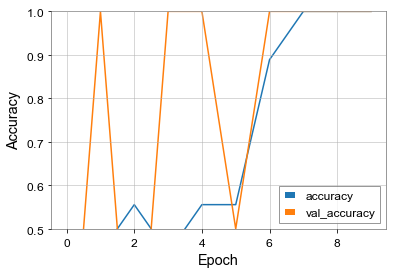

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(qt[8:],  train.loc[8:9, 'target'], verbose=2)

print(test_acc)

In [7]:
train.head

<bound method NDFrame.head of                 id  target                          file_path
0       00000e74ad       1  ./data/train/0/0/0/00000e74ad.npy
1       00001f4945       0  ./data/train/0/0/0/00001f4945.npy
2       0000661522       0  ./data/train/0/0/0/0000661522.npy
3       00007a006a       0  ./data/train/0/0/0/00007a006a.npy
4       0000a38978       1  ./data/train/0/0/0/0000a38978.npy
...            ...     ...                                ...
559995  ffff9a5645       1  ./data/train/f/f/f/ffff9a5645.npy
559996  ffffab0c27       0  ./data/train/f/f/f/ffffab0c27.npy
559997  ffffcf161a       1  ./data/train/f/f/f/ffffcf161a.npy
559998  ffffd2c403       0  ./data/train/f/f/f/ffffd2c403.npy
559999  fffff2180b       0  ./data/train/f/f/f/fffff2180b.npy

[560000 rows x 3 columns]>